In [1]:
import pandas as pd
df=pd.read_csv('ratings.csv')
print(df)

        userId  movieId  rating   timestamp
0            1      307     3.5  1256677221
1            1      481     3.5  1256677456
2            1     1091     1.5  1256677471
3            1     1257     4.5  1256677460
4            1     1449     4.5  1256677264
...        ...      ...     ...         ...
126499    1240     6281     2.0  1446823887
126500    1240     6378     2.5  1446823930
126501    1240     6539     5.0  1446823875
126502    1240     7153     4.0  1446661642
126503    1240     7163     5.0          14

[126504 rows x 4 columns]


In [2]:
print(df.nunique(axis = 0))

userId         1240
movieId       10153
rating           10
timestamp    104148
dtype: int64


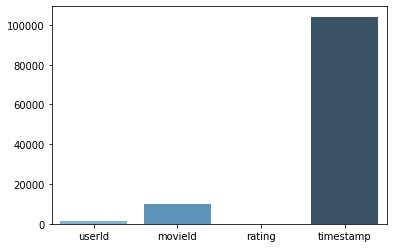

In [3]:
import seaborn as sns
sns.barplot(x=df.columns, y=df.nunique(axis=0), palette="Blues_d")

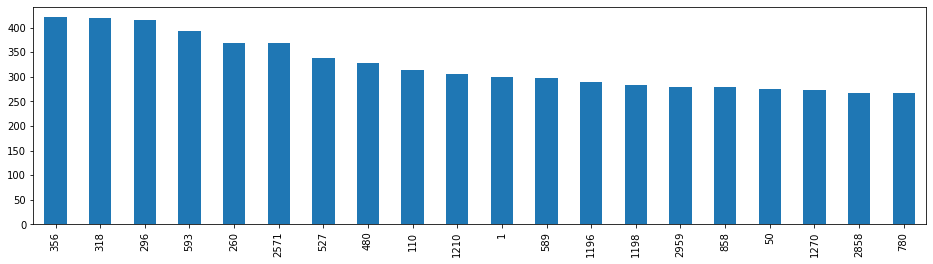

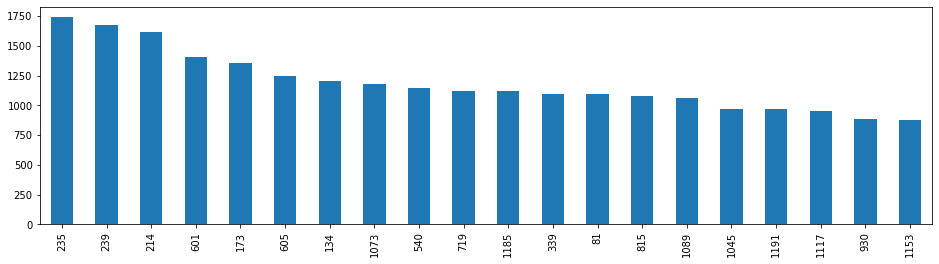

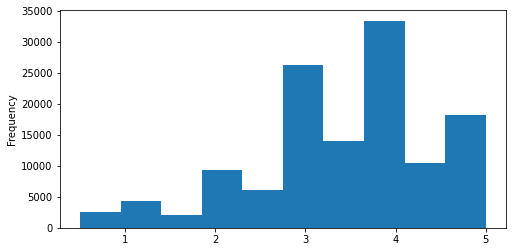

In [4]:
# univariate analysis
import matplotlib.pyplot as plt

plt.figure(1, figsize = (16,4))
#top 20 movies
df['movieId'].value_counts()[:20].plot(kind = 'bar') 
plt.figure(2, figsize = (16,4))
#top 20 users
df['userId'].value_counts()[:20].plot(kind = 'bar') 
plt.figure(3, figsize = (8,4))
df['rating'].plot(kind = 'hist')

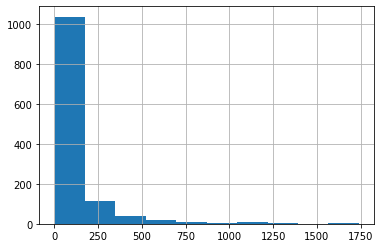

In [5]:
ratings_per_user = df.groupby('userId')['movieId'].count()
ratings_per_user.hist()

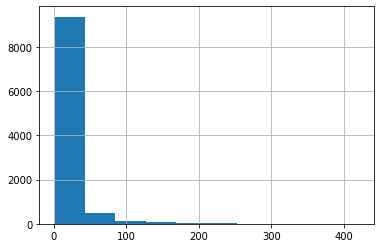

In [6]:
ratings_per_movie = df.groupby('movieId')['userId'].count()
ratings_per_movie.hist()

In [7]:
!pip install surprise
import surprise
from surprise import SVD
# SVD
SVD_algo = SVD()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 4.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633966 sha256=bc3ed982f7d7ceafcc88258cbf896f6e7ece29b437717ff8b36bfadc9dca235d
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [8]:
from surprise import Dataset
from surprise import Reader
# load dataframe into Surprise Reader object
reader = Reader(rating_scale = (0,5))
rating_dataframe = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

In [9]:
from surprise.model_selection import cross_validate

SVD_Cross_Validate = cross_validate(SVD_algo, rating_dataframe, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9350  0.9193  0.9272  0.9433  0.9385  0.9327  0.0085  
MAE (testset)     0.7167  0.7055  0.7123  0.7219  0.7161  0.7145  0.0054  
Fit time          7.70    15.96   6.47    6.53    6.70    8.67    3.67    
Test time         0.63    0.30    0.21    0.19    0.46    0.36    0.17    


In [10]:
from surprise.model_selection import train_test_split
from surprise import accuracy
# define train test function
def train_test_algo(algo, label):
    training_set, testing_set = train_test_split(rating_dataframe, test_size = 0.2)
    algo.fit(training_set)
    test_output = algo.test(testing_set)
    test_dataframe = pd.DataFrame(test_output)
    
    print("RMSE -",label, accuracy.rmse(test_output, verbose = False))
    print("MAE -", label, accuracy.mae(test_output, verbose=False))
    print("MSE -", label, accuracy.mse(test_output, verbose=False))
    
    return test_dataframe

In [11]:
train_test_SVD = train_test_algo(SVD_algo, "SVD_algo")
print(train_test_SVD.head())

RMSE - SVD_algo 0.9331146290334653
MAE - SVD_algo 0.7128850543850416
MSE - SVD_algo 0.8707029109162615
    uid    iid  r_ui       est                    details
0  1212   5152   4.0  3.160928  {'was_impossible': False}
1   366    114   4.0  3.239993  {'was_impossible': False}
2   627   1429   3.5  2.941785  {'was_impossible': False}
3   295   5339   5.0  3.577663  {'was_impossible': False}
4   526  80185   3.5  3.346382  {'was_impossible': False}


In [12]:
movie_dataframe = pd.read_csv("movies.csv")
links_dataframe = pd.read_csv("links.csv")
movie_dataframe['movieId'] = movie_dataframe['movieId'].apply(lambda x: str(x)[2:].lstrip("0"))
# movie_dataframe['movieId'] = movie_dataframe['movieId'].astype(str)
links_dataframe['movieId'] = links_dataframe['movieId'].astype(str)

In [13]:
def prediction(algo, users_K):
    prediction_list = []
    for userId in range(1,users_K):
        for movieId in range(1,9067):
            rating = algo.predict(userId, movieId).est
            prediction_list.append([userId, movieId, rating])
    prediction_dataframe = pd.DataFrame(prediction_list, columns = ['userId', 'movieId', 'rating'])
    return prediction_dataframe

In [19]:
def top_recommendations_movies(prediction_dataframe, top_N):
    print("Prediction data frame")
    print('\n')
    print(prediction_dataframe)
    print('\n')
    prediction_dataframe['movieId']=prediction_dataframe['movieId'].astype(str)
    link_movie = pd.merge(prediction_dataframe, links_dataframe, how='inner', left_on='movieId', right_on='movieId')
    print("link data frame")
    print('\n')
    print(link_movie)
    print('\n')
    rec_movie = pd.merge(link_movie, movie_dataframe, how='left', left_on='movieId', right_on='movieId')[['userId', 'movieId', 'rating', 'movieId','imdbId','title']]
    print("recommended movies data frame")
    print('\n')
    print(rec_movie)
    print('\n')
    sorted_df = rec_movie.groupby(('userId'), as_index = False).apply(lambda x: x.sort_values(['rating'], ascending = False)).reset_index(drop=True)
    top_rec_movies = sorted_df.groupby('userId').head(top_N)
    return sorted_df, top_rec_movies

In [24]:
## SVD predictions for the MovieLens Large Dataset
pred_SVD = prediction(SVD_algo, 10)
rec_movies_SVD, top_rec_movies_SVD = top_recommendations_movies(pred_SVD, 3)
print('\n')
print('\n')
print("Top Three Movies Recommendations")
print(top_rec_movies_SVD[:3])

Prediction data frame


       userId  movieId    rating
0           1        1  3.924389
1           1        2  3.045577
2           1        3  2.996303
3           1        4  3.170794
4           1        5  2.983442
...       ...      ...       ...
81589       9     9062  3.564377
81590       9     9063  3.564377
81591       9     9064  3.564377
81592       9     9065  3.564377
81593       9     9066  3.564377

[81594 rows x 3 columns]


link data frame


       userId movieId    rating  imdbId    tmdbId
0           1       1  3.924389  114709     862.0
1           2       1  3.991356  114709     862.0
2           3       1  3.913613  114709     862.0
3           4       1  3.555299  114709     862.0
4           5       1  4.209920  114709     862.0
...       ...     ...       ...     ...       ...
75028       5    9019  3.844007  424885  210864.0
75029       6    9019  3.619328  424885  210864.0
75030       7    9019  3.387076  424885  210864.0
75031       8    9019  3.462037  4